In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [8]:
df = pd.read_csv('gps_data_outlier_preprocessed.csv', index_col=0)

In [9]:
df.head()

,time,lat,lon,gps_time,driver_hash,fraud,gps_delta,gps_distance,gps_speed,gps_accel,...,tm_trip_max_speed,tm_trip_mean_accel,tm_trip_median_accel,tm_trip_max_accel,sin_hours,sin_min,sin_sec,cos_hours,cos_min,cos_sec
0,2020-11-10 03:08:12,55.473589,37.705870,2020-11-10 03:08:12,-9218579406240981296,-1,0.0,0.0,0.000000,0.00000,...,0.00000,0.000000,0.00000,0.000000,0.707107,0.743145,9.510565e-01,7.071068e-01,0.669131,3.090170e-01
1,2020-11-10 03:42:48,55.473589,37.705870,2020-11-10 03:42:48,-9218579406240981296,-1,0.0,0.0,0.000000,0.00000,...,0.00000,0.000000,0.00000,0.000000,0.707107,-0.951057,-9.510565e-01,7.071068e-01,-0.309017,3.090170e-01
2,2020-11-10 06:38:31,55.473589,37.705870,2020-11-10 06:38:30,-9218579406240981296,-1,0.0,0.0,0.000000,0.00000,...,0.00000,0.000000,0.00000,0.000000,1.000000,-0.743145,1.224647e-16,6.123234e-17,-0.669131,-1.000000e+00
3,2020-11-10 06:54:36,55.473589,37.705870,2020-11-10 06:54:36,-9218579406240981296,-1,0.0,0.0,0.000000,0.00000,...,4259.41581,266.233163,0.00029,1419.780337,1.000000,-0.587785,-5.877853e-01,6.123234e-17,0.809017,-8.090170e-01
4,2020-11-10 06:56:45,55.473520,37.705963,2020-11-10 06:56:45,-9218579406240981296,-1,129.0,9.6,0.074798,0.00058,...,4259.41581,266.233163,0.00029,1419.780337,1.000000,-0.406737,-1.000000e+00,6.123234e-17,0.913545,-1.836970e-16


In [10]:
df.columns

Index(['time', 'lat', 'lon', 'gps_time', 'driver_hash', 'fraud', 'gps_delta',
       'gps_distance', 'gps_speed', 'gps_accel', 'gps_outlier', 'gps_staying',
       'tm_delta', 'tm_distance', 'tm_speed', 'tm_accel', 'tm_outlier',
       'tm_staying', 'is_trip_start', 'is_buisness_day', 'is_rush_hour',
       'gps_trip_duration', 'gps_trip_mean_timedelta',
       'gps_trip_median_timedelta', 'gps_trip_max_timedelta',
       'gps_trip_cum_timedelta', 'gps_trip_length', 'gps_trip_mean_dist',
       'gps_trip_median_dist', 'gps_trip_max_dist', 'gps_trip_cum_dist',
       'gps_trip_mean_speed', 'gps_trip_median_speed', 'gps_trip_max_speed',
       'gps_trip_mean_accel', 'gps_trip_median_accel', 'gps_trip_max_accel',
       'tm_trip_duration', 'tm_trip_mean_timedelta',
       'tm_trip_median_timedelta', 'tm_trip_max_timedelta',
       'tm_trip_cum_timedelta', 'tm_trip_length', 'tm_trip_mean_dist',
       'tm_trip_median_dist', 'tm_trip_max_dist', 'tm_trip_cum_dist',
       'tm_trip_mean_speed

In [107]:
features = [
    'gps_delta',
       'gps_distance', 'gps_speed', 'gps_accel', 'gps_outlier', 'gps_staying',
       'tm_delta', 'tm_distance', 'tm_speed', 'tm_accel', 'tm_outlier',
       'tm_staying', 'is_trip_start', 'is_buisness_day', 'is_rush_hour',
       'gps_trip_duration', 'gps_trip_mean_timedelta',
       'gps_trip_median_timedelta', 'gps_trip_max_timedelta',
       'gps_trip_cum_timedelta', 'gps_trip_length', 'gps_trip_mean_dist',
       'gps_trip_median_dist', 'gps_trip_max_dist', 'gps_trip_cum_dist',
       'gps_trip_mean_speed', 'gps_trip_median_speed', 'gps_trip_max_speed',
       'gps_trip_mean_accel', 'gps_trip_median_accel', 'gps_trip_max_accel',
       'tm_trip_duration', 'tm_trip_mean_timedelta',
       'tm_trip_median_timedelta', 'tm_trip_max_timedelta',
       'tm_trip_cum_timedelta', 'tm_trip_length', 'tm_trip_mean_dist',
       'tm_trip_median_dist', 'tm_trip_max_dist', 'tm_trip_cum_dist',
       'tm_trip_mean_speed', 'tm_trip_median_speed', 'tm_trip_max_speed',
       'tm_trip_mean_accel', 'tm_trip_median_accel', 'tm_trip_max_accel',
       'sin_hours', 'sin_min', 'sin_sec', 'cos_hours', 'cos_min', 'cos_sec'
]

In [108]:
len(features)

53

In [109]:
X = df[features]

## Отсеим признаки с высокой корреляцией

In [110]:
corr_matrix = X.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.7
to_drop = [column for column in upper.columns if any(upper[column] > 0.7)]

so = corr_matrix.unstack().sort_values(kind="quicksort", ascending=False)

for row in pd.DataFrame(so).iterrows():
    print(row[0], row[-1][0])

('cos_sec', 'cos_sec') 1.0
('tm_trip_median_dist', 'tm_trip_median_dist') 1.0
('gps_trip_mean_accel', 'gps_trip_mean_accel') 1.0
('gps_trip_median_accel', 'gps_trip_median_accel') 1.0
('gps_trip_max_accel', 'gps_trip_max_accel') 1.0
('tm_trip_duration', 'tm_trip_duration') 1.0
('tm_trip_mean_timedelta', 'tm_trip_mean_timedelta') 1.0
('tm_trip_median_timedelta', 'tm_trip_median_timedelta') 1.0
('tm_trip_max_timedelta', 'tm_trip_max_timedelta') 1.0
('tm_trip_cum_timedelta', 'tm_trip_cum_timedelta') 1.0
('tm_trip_length', 'tm_trip_length') 1.0
('tm_trip_mean_dist', 'tm_trip_mean_dist') 1.0
('tm_trip_max_dist', 'tm_trip_max_dist') 1.0
('gps_trip_mean_speed', 'gps_trip_mean_speed') 1.0
('tm_trip_cum_dist', 'tm_trip_cum_dist') 1.0
('tm_trip_mean_speed', 'tm_trip_mean_speed') 1.0
('tm_trip_median_speed', 'tm_trip_median_speed') 1.0
('tm_trip_max_speed', 'tm_trip_max_speed') 1.0
('tm_trip_mean_accel', 'tm_trip_mean_accel') 1.0
('tm_trip_median_accel', 'tm_trip_median_accel') 1.0
('tm_trip_max_

('tm_trip_cum_timedelta', 'tm_delta') 0.0297351772387055
('tm_delta', 'tm_trip_cum_timedelta') 0.0297351772387055
('tm_trip_cum_dist', 'tm_distance') 0.02970139831401516
('tm_distance', 'tm_trip_cum_dist') 0.02970139831401516
('gps_distance', 'tm_trip_cum_dist') 0.029672514213438358
('tm_trip_cum_dist', 'gps_distance') 0.029672514213438358
('tm_trip_duration', 'tm_delta') 0.029638644894453958
('tm_delta', 'tm_trip_duration') 0.029638644894453958
('tm_trip_cum_timedelta', 'gps_trip_duration') 0.02958400952319086
('gps_trip_duration', 'tm_trip_cum_timedelta') 0.02958400952319086
('tm_speed', 'tm_trip_max_accel') 0.029424737779791824
('tm_trip_max_accel', 'tm_speed') 0.029424737779791824
('is_buisness_day', 'tm_trip_cum_timedelta') 0.029420679991323237
('tm_trip_cum_timedelta', 'is_buisness_day') 0.029420679991323237
('tm_trip_mean_dist', 'gps_outlier') 0.02928598239188443
('gps_outlier', 'tm_trip_mean_dist') 0.02928598239188443
('sin_hours', 'tm_trip_max_timedelta') 0.02928299072954838
(

('is_buisness_day', 'gps_trip_max_timedelta') 0.013626313700518282
('gps_trip_max_timedelta', 'is_buisness_day') 0.013626313700518282
('is_buisness_day', 'gps_trip_max_accel') 0.013438538106261276
('gps_trip_max_accel', 'is_buisness_day') 0.013438538106261276
('tm_trip_median_accel', 'is_rush_hour') 0.013386785856275315
('is_rush_hour', 'tm_trip_median_accel') 0.013386785856275315
('gps_staying', 'gps_trip_duration') 0.01337556826311784
('gps_trip_duration', 'gps_staying') 0.01337556826311784
('tm_trip_cum_timedelta', 'gps_trip_length') 0.013359724791826127
('gps_trip_length', 'tm_trip_cum_timedelta') 0.013359724791826127
('tm_trip_max_speed', 'tm_accel') 0.013254020221202697
('tm_accel', 'tm_trip_max_speed') 0.013254020221202697
('tm_trip_mean_accel', 'is_rush_hour') 0.013140838336724981
('is_rush_hour', 'tm_trip_mean_accel') 0.013140838336724981
('tm_trip_median_speed', 'tm_speed') 0.013130201521850387
('tm_speed', 'tm_trip_median_speed') 0.013130201521850387
('tm_trip_mean_dist', 'g

('gps_staying', 'tm_speed') 0.0031415259738545587
('tm_trip_max_accel', 'gps_delta') 0.003132642381547944
('gps_delta', 'tm_trip_max_accel') 0.003132642381547944
('gps_outlier', 'tm_trip_median_accel') 0.003123610653439536
('tm_trip_median_accel', 'gps_outlier') 0.003123610653439536
('tm_trip_max_timedelta', 'tm_trip_max_dist') 0.0031102641563561517
('tm_trip_max_dist', 'tm_trip_max_timedelta') 0.0031102641563561517
('gps_trip_median_dist', 'gps_trip_cum_dist') 0.003088894219801716
('gps_trip_cum_dist', 'gps_trip_median_dist') 0.003088894219801716
('gps_trip_cum_dist', 'tm_trip_median_speed') 0.0030582645544063175
('tm_trip_median_speed', 'gps_trip_cum_dist') 0.0030582645544063175
('sin_hours', 'gps_trip_max_accel') 0.003052099187185158
('gps_trip_max_accel', 'sin_hours') 0.003052099187185158
('gps_trip_cum_dist', 'tm_trip_median_dist') 0.0030513085101298767
('tm_trip_median_dist', 'gps_trip_cum_dist') 0.0030513085101298767
('tm_trip_max_speed', 'tm_trip_median_dist') 0.003040662765827

('gps_trip_median_speed', 'tm_delta') 0.0003161226130085532
('is_buisness_day', 'gps_speed') 0.0003132101307863925
('gps_speed', 'is_buisness_day') 0.0003132101307863925
('sin_sec', 'tm_trip_max_speed') 0.0003103721944985737
('tm_trip_max_speed', 'sin_sec') 0.0003103721944985737
('is_buisness_day', 'sin_sec') 0.00030957271606434143
('sin_sec', 'is_buisness_day') 0.00030957271606434143
('sin_min', 'gps_trip_duration') 0.00030562163049573186
('gps_trip_duration', 'sin_min') 0.00030562163049573186
('sin_sec', 'gps_distance') 0.00030528453115872937
('gps_distance', 'sin_sec') 0.00030528453115872937
('sin_sec', 'tm_distance') 0.0003048977858294523
('tm_distance', 'sin_sec') 0.0003048977858294523
('gps_distance', 'tm_trip_median_speed') 0.00030394634038136777
('tm_trip_median_speed', 'gps_distance') 0.00030394634038136777
('tm_trip_median_accel', 'gps_trip_max_speed') 0.0003008571777094617
('gps_trip_max_speed', 'tm_trip_median_accel') 0.0003008571777094617
('sin_hours', 'tm_distance') 0.000

In [111]:
to_drop

['gps_speed',
 'tm_distance',
 'tm_speed',
 'tm_accel',
 'tm_staying',
 'gps_trip_median_timedelta',
 'gps_trip_cum_timedelta',
 'gps_trip_mean_dist',
 'gps_trip_max_dist',
 'gps_trip_cum_dist',
 'gps_trip_mean_speed',
 'gps_trip_max_speed',
 'gps_trip_max_accel',
 'tm_trip_max_timedelta',
 'tm_trip_cum_timedelta',
 'tm_trip_length',
 'tm_trip_mean_dist',
 'tm_trip_median_dist',
 'tm_trip_max_dist',
 'tm_trip_cum_dist',
 'tm_trip_mean_speed',
 'tm_trip_max_speed',
 'tm_trip_mean_accel',
 'tm_trip_median_accel',
 'tm_trip_max_accel']

In [112]:
X.drop(to_drop, axis=1, inplace=True)
X.shape

(5020511, 28)

## Обучение K-Means

In [113]:
models = {i: KMeans(n_clusters=i, max_iter=100000, random_state=42) for i in range(2, 11)}

In [114]:
for i, model in models.items():
    model.fit(X)
    print(f'Fit model {i}')

Fit model 2
Fit model 3
Fit model 4
Fit model 5
Fit model 6
Fit model 7
Fit model 8
Fit model 9
Fit model 10


In [116]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

## 2 кластера

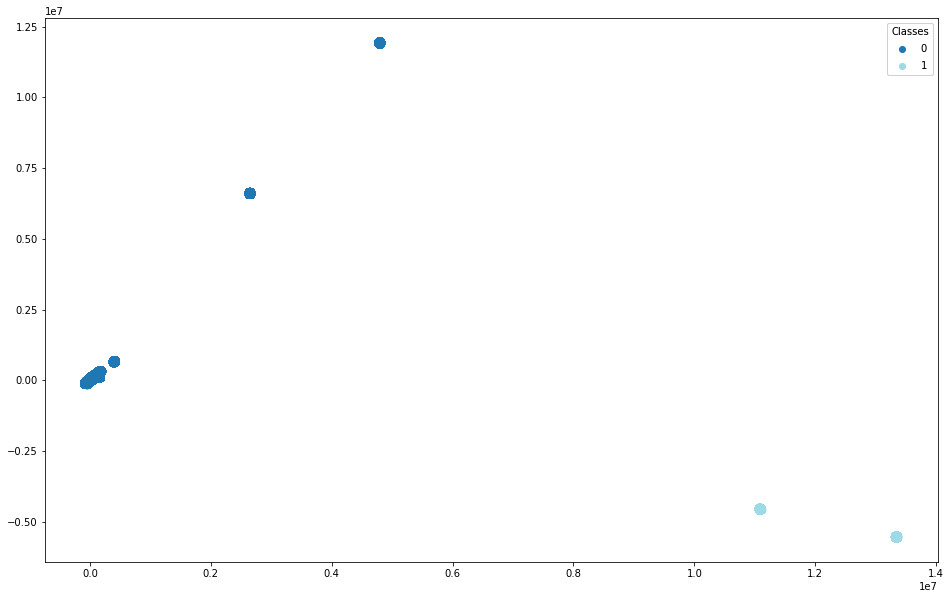

In [118]:
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(16)

model = models[2]
y = model.predict(X)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=100, cmap='tab20')
legend = ax.legend(*scatter.legend_elements(), title="Classes")
ax.add_artist(legend)
plt.show()

In [119]:
y = pd.Series(y)
y.value_counts()

0    5017790
1       2721
dtype: int64

In [120]:
cluster_df = pd.DataFrame({'fraud': df.fraud.copy(), 'cluster': y})
for i in cluster_df.cluster.unique():
    group = cluster_df[cluster_df.cluster == i]
    fraud = group.fraud.value_counts()[1] if 1 in group.fraud.value_counts().index else 0
    print(f'Процент фрода в кластере {i}: {fraud / len(group) * 100:.2f}%')

Процент фрода в кластере 0: 2.12%
Процент фрода в кластере 1: 3.79%


## 3 кластера

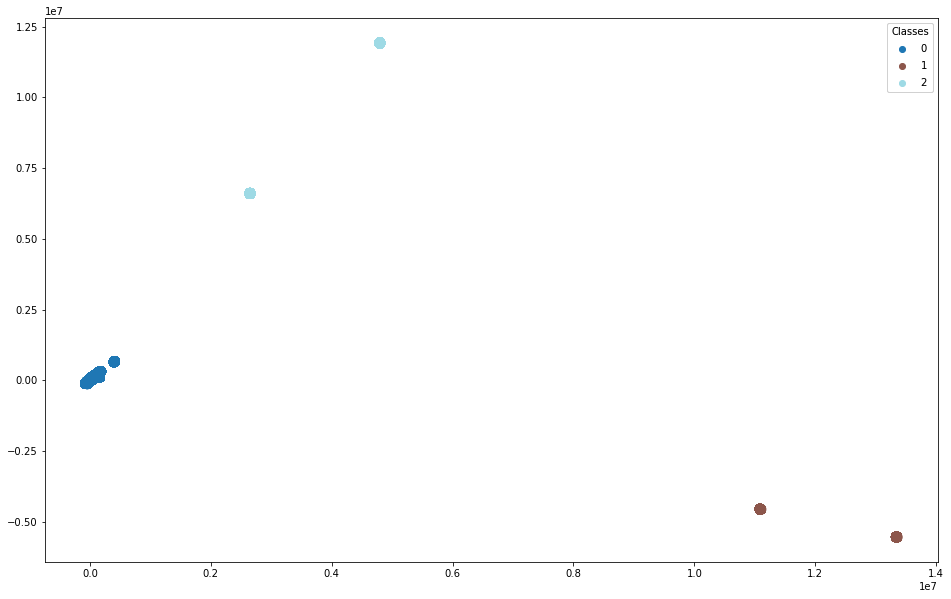

In [121]:
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(16)

model = models[3]
y = model.predict(X)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=100, cmap='tab20')
legend = ax.legend(*scatter.legend_elements(), title="Classes")
ax.add_artist(legend)
plt.show()

In [122]:
y = pd.Series(y)
y.value_counts()

0    5014822
2       2968
1       2721
dtype: int64

In [123]:
cluster_df = pd.DataFrame({'fraud': df.fraud.copy(), 'cluster': y})
for i in cluster_df.cluster.unique():
    group = cluster_df[cluster_df.cluster == i]
    fraud = group.fraud.value_counts()[1] if 1 in group.fraud.value_counts().index else 0
    print(f'Процент фрода в кластере {i}: {fraud / len(group) * 100:.2f}%')

Процент фрода в кластере 0: 2.10%
Процент фрода в кластере 1: 3.79%
Процент фрода в кластере 2: 40.46%


## 4 кластера

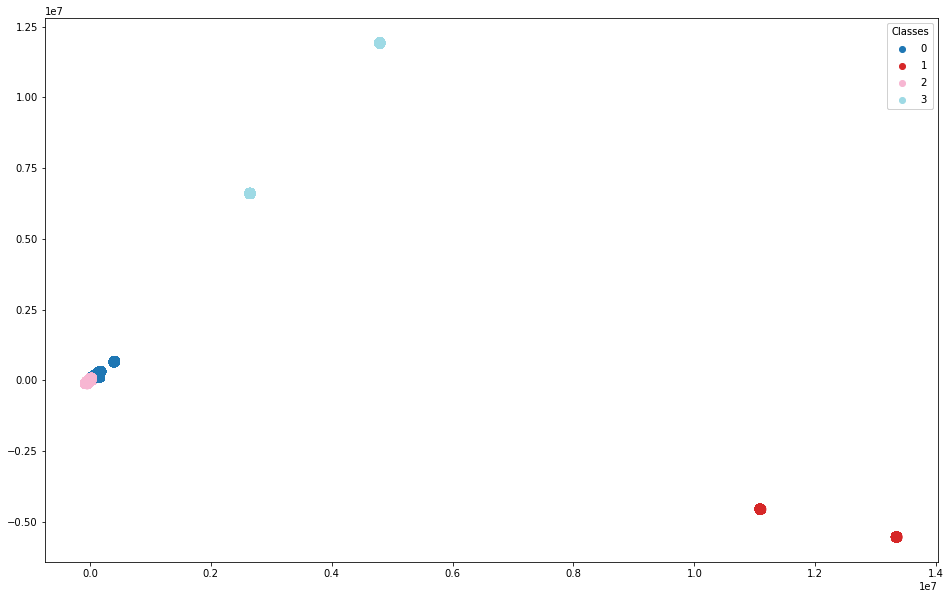

In [124]:
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(16)

model = models[4]
y = model.predict(X)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=100, cmap='tab20')
legend = ax.legend(*scatter.legend_elements(), title="Classes")
ax.add_artist(legend)
plt.show()

In [125]:
y = pd.Series(y)
y.value_counts()

2    4341664
0     673158
3       2968
1       2721
dtype: int64

In [126]:
cluster_df = pd.DataFrame({'fraud': df.fraud.copy(), 'cluster': y})
for i in cluster_df.cluster.unique():
    group = cluster_df[cluster_df.cluster == i]
    fraud = group.fraud.value_counts()[1] if 1 in group.fraud.value_counts().index else 0
    print(f'Процент фрода в кластере {i}: {fraud / len(group) * 100:.2f}%')

Процент фрода в кластере 2: 2.42%
Процент фрода в кластере 0: 0.00%
Процент фрода в кластере 1: 3.79%
Процент фрода в кластере 3: 40.46%


## 5 кластеров

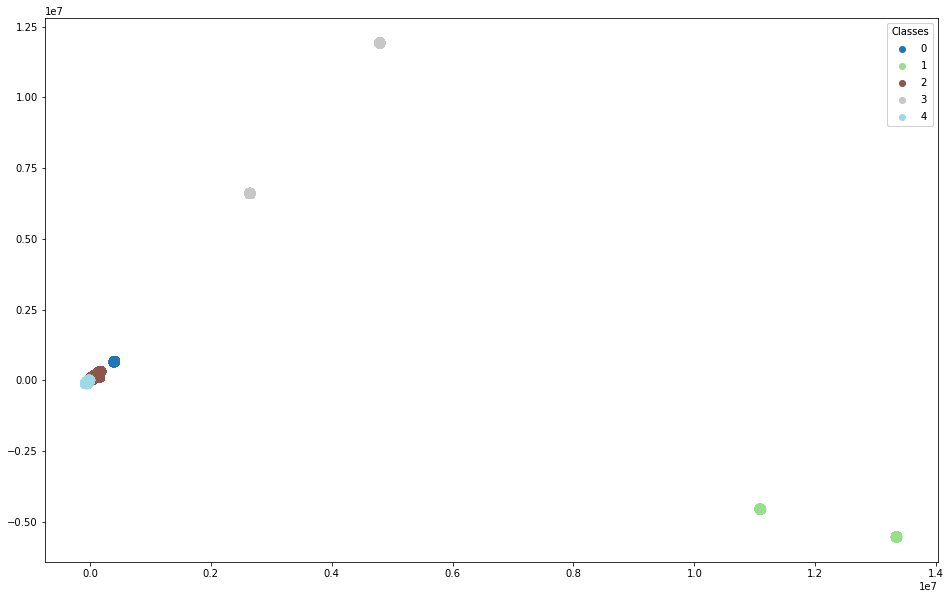

In [127]:
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(16)

model = models[5]
y = model.predict(X)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=100, cmap='tab20')
legend = ax.legend(*scatter.legend_elements(), title="Classes")
ax.add_artist(legend)
plt.show()

In [128]:
y = pd.Series(y)
y.value_counts()

4    3769917
2    1169346
0      75559
3       2968
1       2721
dtype: int64

In [129]:
cluster_df = pd.DataFrame({'fraud': df.fraud.copy(), 'cluster': y})
for i in cluster_df.cluster.unique():
    group = cluster_df[cluster_df.cluster == i]
    fraud = group.fraud.value_counts()[1] if 1 in group.fraud.value_counts().index else 0
    print(f'Процент фрода в кластере {i}: {fraud / len(group) * 100:.2f}%')

Процент фрода в кластере 4: 2.59%
Процент фрода в кластере 2: 0.65%
Процент фрода в кластере 1: 3.79%
Процент фрода в кластере 3: 40.46%
Процент фрода в кластере 0: 0.00%


## 6 кластеров

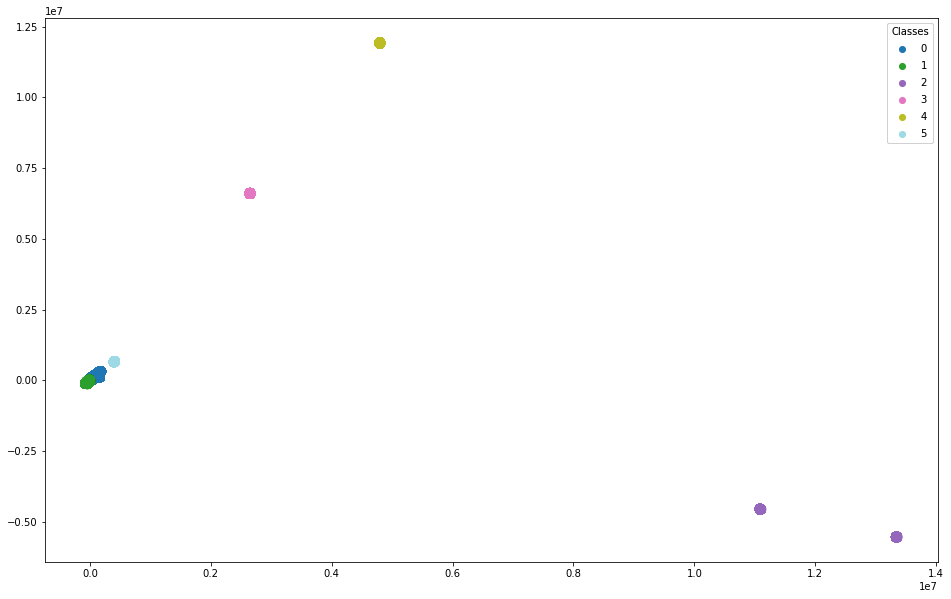

In [130]:
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(16)

model = models[6]
y = model.predict(X)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=100, cmap='tab20')
legend = ax.legend(*scatter.legend_elements(), title="Classes")
ax.add_artist(legend)
plt.show()

In [131]:
y = pd.Series(y)
y.value_counts()

1    3784142
0    1155121
5      75559
2       2721
3       1767
4       1201
dtype: int64

In [132]:
cluster_df = pd.DataFrame({'fraud': df.fraud.copy(), 'cluster': y})
for i in cluster_df.cluster.unique():
    group = cluster_df[cluster_df.cluster == i]
    fraud = group.fraud.value_counts()[1] if 1 in group.fraud.value_counts().index else 0
    print(f'Процент фрода в кластере {i}: {fraud / len(group) * 100:.2f}%')

Процент фрода в кластере 1: 2.58%
Процент фрода в кластере 0: 0.66%
Процент фрода в кластере 2: 3.79%
Процент фрода в кластере 3: 0.00%
Процент фрода в кластере 4: 100.00%
Процент фрода в кластере 5: 0.00%


## 7 кластеров

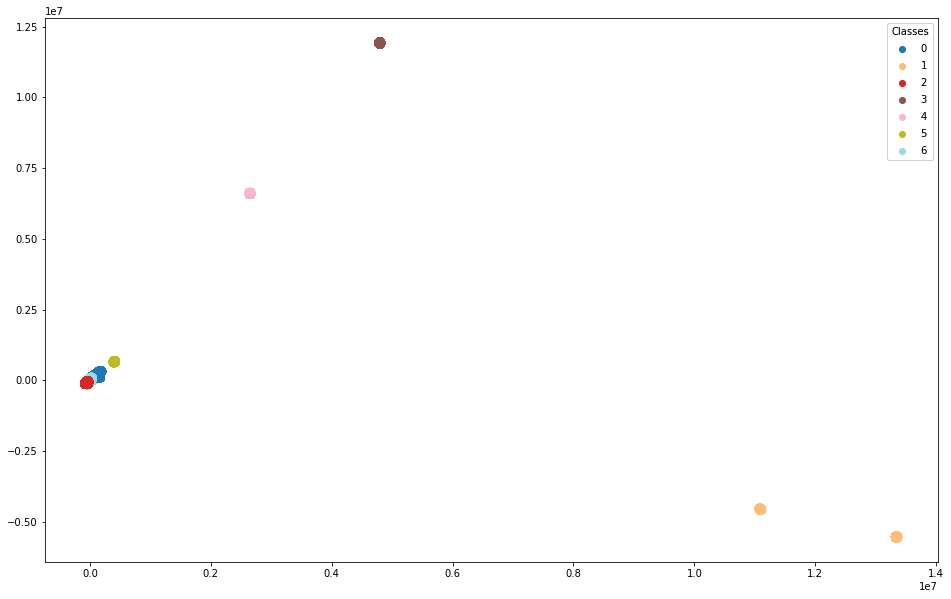

In [133]:
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(16)

model = models[7]
y = model.predict(X)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=100, cmap='tab20')
legend = ax.legend(*scatter.legend_elements(), title="Classes")
ax.add_artist(legend)
plt.show()

In [134]:
y = pd.Series(y)
y.value_counts()

2    2690874
6    1638786
0     609603
5      75559
1       2721
4       1767
3       1201
dtype: int64

In [135]:
cluster_df = pd.DataFrame({'fraud': df.fraud.copy(), 'cluster': y})
for i in cluster_df.cluster.unique():
    group = cluster_df[cluster_df.cluster == i]
    fraud = group.fraud.value_counts()[1] if 1 in group.fraud.value_counts().index else 0
    print(f'Процент фрода в кластере {i}: {fraud / len(group) * 100:.2f}%')

Процент фрода в кластере 2: 3.16%
Процент фрода в кластере 6: 1.23%
Процент фрода в кластере 0: 0.00%
Процент фрода в кластере 1: 3.79%
Процент фрода в кластере 4: 0.00%
Процент фрода в кластере 3: 100.00%
Процент фрода в кластере 5: 0.00%


## 8 кластеров

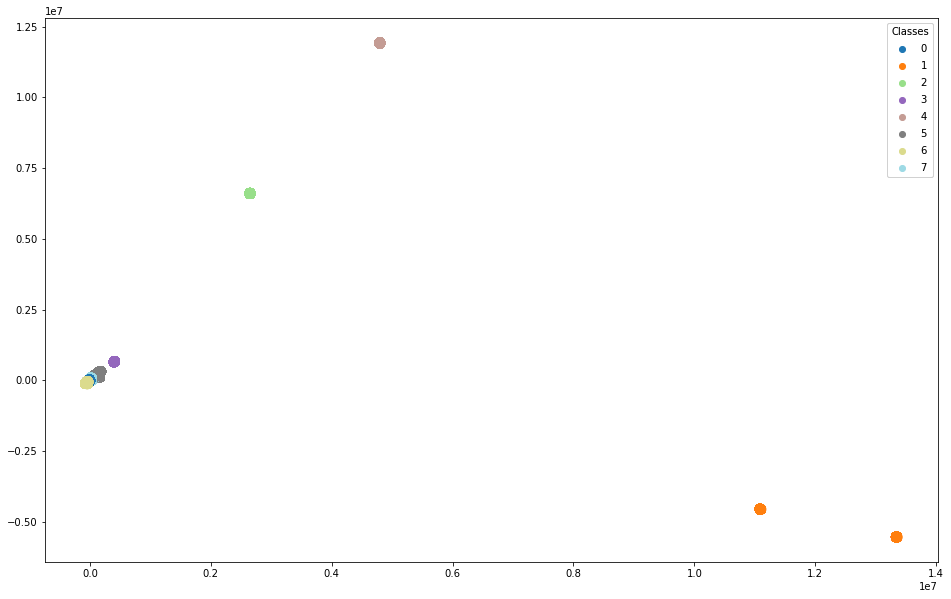

In [136]:
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(16)

model = models[8]
y = model.predict(X)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=100, cmap='tab20')
legend = ax.legend(*scatter.legend_elements(), title="Classes")
ax.add_artist(legend)
plt.show()

In [137]:
y = pd.Series(y)
y.value_counts()

6    2229515
0    1489854
7     777056
5     442838
3      75559
1       2721
2       1767
4       1201
dtype: int64

In [138]:
cluster_df = pd.DataFrame({'fraud': df.fraud.copy(), 'cluster': y})
for i in cluster_df.cluster.unique():
    group = cluster_df[cluster_df.cluster == i]
    fraud = group.fraud.value_counts()[1] if 1 in group.fraud.value_counts().index else 0
    print(f'Процент фрода в кластере {i}: {fraud / len(group) * 100:.2f}%')

Процент фрода в кластере 6: 3.74%
Процент фрода в кластере 0: 0.78%
Процент фрода в кластере 7: 1.29%
Процент фрода в кластере 1: 3.79%
Процент фрода в кластере 2: 0.00%
Процент фрода в кластере 5: 0.00%
Процент фрода в кластере 4: 100.00%
Процент фрода в кластере 3: 0.00%


## 9 кластеров

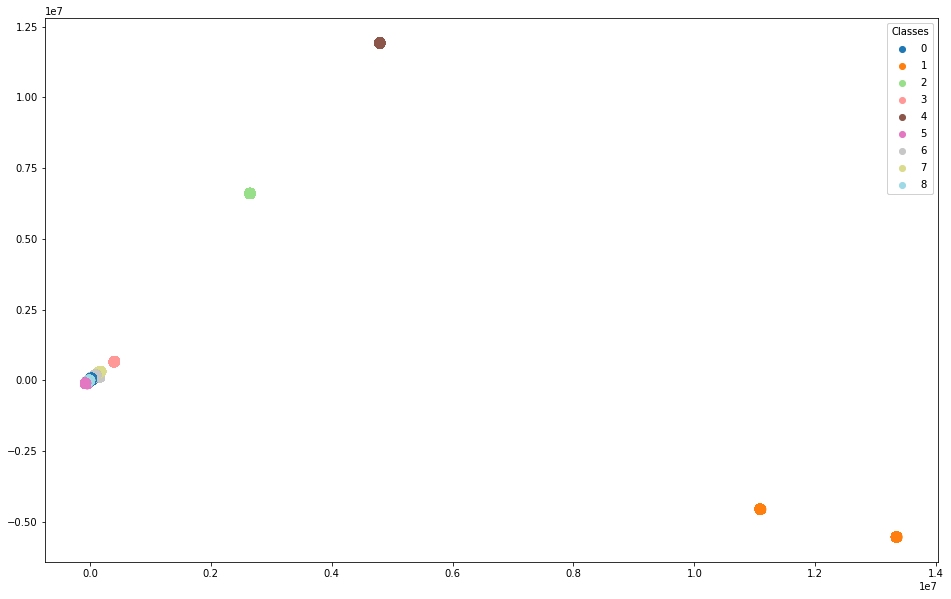

In [139]:
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(16)

model = models[9]
y = model.predict(X)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=100, cmap='tab20')
legend = ax.legend(*scatter.legend_elements(), title="Classes")
ax.add_artist(legend)
plt.show()

In [140]:
y = pd.Series(y)
y.value_counts()

5    1901517
8    1525105
0     915042
6     527221
3      75559
7      70378
1       2721
2       1767
4       1201
dtype: int64

In [141]:
cluster_df = pd.DataFrame({'fraud': df.fraud.copy(), 'cluster': y})
for i in cluster_df.cluster.unique():
    group = cluster_df[cluster_df.cluster == i]
    fraud = group.fraud.value_counts()[1] if 1 in group.fraud.value_counts().index else 0
    print(f'Процент фрода в кластере {i}: {fraud / len(group) * 100:.2f}%')

Процент фрода в кластере 5: 4.39%
Процент фрода в кластере 8: 0.77%
Процент фрода в кластере 0: 1.10%
Процент фрода в кластере 6: 0.00%
Процент фрода в кластере 1: 3.79%
Процент фрода в кластере 2: 0.00%
Процент фрода в кластере 4: 100.00%
Процент фрода в кластере 3: 0.00%
Процент фрода в кластере 7: 0.00%


## 10 кластеров

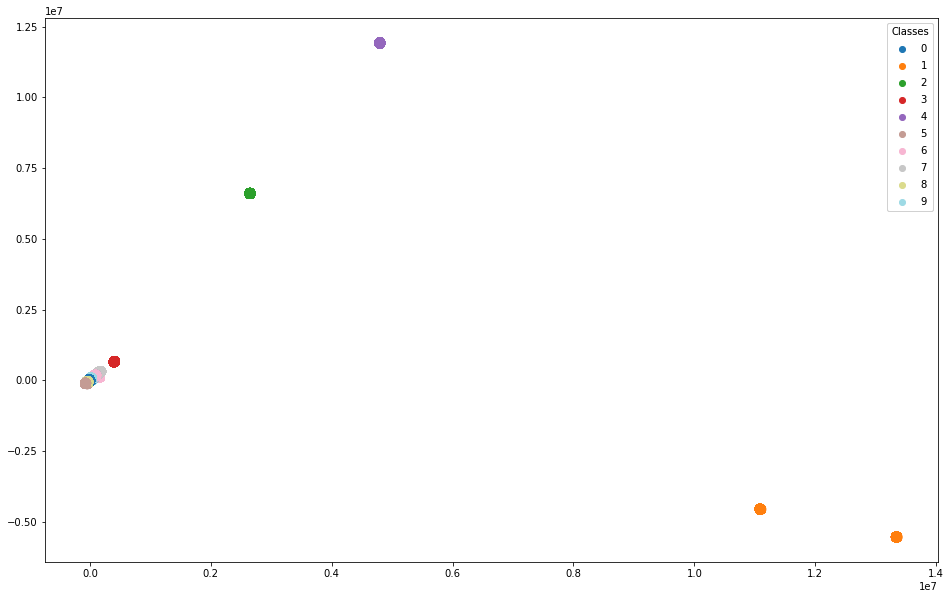

In [142]:
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(16)

model = models[10]
y = model.predict(X)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=100, cmap='tab20')
legend = ax.legend(*scatter.legend_elements(), title="Classes")
ax.add_artist(legend)
plt.show()

In [143]:
y = pd.Series(y)
y.value_counts()

5    1605456
8    1331759
0    1115003
9     444207
6     372460
3      75559
7      70378
1       2721
2       1767
4       1201
dtype: int64

In [144]:
cluster_df = pd.DataFrame({'fraud': df.fraud.copy(), 'cluster': y})
for i in cluster_df.cluster.unique():
    group = cluster_df[cluster_df.cluster == i]
    fraud = group.fraud.value_counts()[1] if 1 in group.fraud.value_counts().index else 0
    print(f'Процент фрода в кластере {i}: {fraud / len(group) * 100:.2f}%')

Процент фрода в кластере 5: 5.01%
Процент фрода в кластере 0: 0.84%
Процент фрода в кластере 8: 0.59%
Процент фрода в кластере 9: 1.72%
Процент фрода в кластере 1: 3.79%
Процент фрода в кластере 2: 0.00%
Процент фрода в кластере 6: 0.00%
Процент фрода в кластере 4: 100.00%
Процент фрода в кластере 3: 0.00%
Процент фрода в кластере 7: 0.00%
